# COVID19 Project

In [2]:
__author__ = "Kyle M Reaves"
__github__ = "https://www.github.com/kylemichaelreaves"

import pandas as pd, matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta

#dtype changed to category from object to optimize runtime
df =  pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv", 
dtype={'county': 'category','state': 'category'})

df.date = pd.to_datetime(df.date)

df['cases_diff'] = df.groupby(['county', 'state'])['cases'].diff()
df['deaths_diff'] = df.groupby(['county', 'state'])['deaths'].diff()

df.set_index(df.date, inplace=True, drop=True)
df.drop(columns=['date'], inplace=True)
df.sort_index(ascending=False, inplace=True)

states = df.state.unique().tolist()
counties = df.county.unique().tolist()
fips = df.fips.unique().tolist()
total_cases = df.xs(df.index[0])['cases'].sum()
total_deaths = df.xs(df.index[0])['deaths'].sum()

In [82]:
def greatest_cases_yesterday():
    gcy = df.sort_values(by=['date', 'cases_diff'], ascending=False)
    return gcy.xs(df.index[0])

def greatest_deaths_yesterday():
    gdy = df.sort_values(by=['date', 'deaths_diff'], ascending=False)
    return gdy.xs(df.index[0])

def county_df(county, state=None):
    county_df = df[df['county'] == county].drop(columns=['county'])
    
    if state is not None and state not in states:
        return "{0} is not a state in the dataframe.".format(state)
    
    if state is not None:
        county_df = df[(df.county == county) & (df.state == state)]
        return county_df
    
    if county in states:
        return "{0} is not a county but a state.".format(county)
    
    if county not in counties:
        return "{0} is not a county in the dataframe.".format(county)
    
    also_in = county_df.state.unique()
    num_counties = len(also_in)
    
    if num_counties == 1:
        county_df.drop(columns=['state', 'fips'], axis=1, inplace=True)
        
    if num_counties > 1:
        return "{0} appears in {1}; please specify.".format(county, also_in)
    
    return county_df


def state_df(state):
    if state not in states:
        return "{0} is not in database.".format(state)
    
    sdf = df[df.state == state].copy()
    
    counties = sdf.county.unique()
    
    sdf.sort_index(ascending=False, inplace=True)
    sdf.drop(columns=['fips'], inplace=True)
    return sdf


def daily_df(state=None):
    if state is None:
        index = df.index.unique()
        data = {'cases': [df.xs(i)['cases_diff'].sum() for i in index],
               'deaths': [df.xs(i)['deaths_diff'].sum() for i in index]}
        df2 = pd.DataFrame(data, index)

    if state:
        index = state_df(state).index.unique()
        data = {'cases': [state_df(state).xs(i)['cases_diff'].sum() for i in index],
               'deaths': [state_df(state).xs(i)['deaths_diff'].sum() for i in index]}
        df2 = pd.DataFrame(data, index)
        return df2
    else:
        return df2
    

def yesterday():
    #yest = (dt.now() - timedelta(days=1)).strftime('%D')
    cases_max = daily_df()['cases'].idxmax().strftime("%D")
    deaths_max = daily_df()['deaths'].idxmax().strftime("%D")
    cases = df.xs(df.index[0])['cases_diff'].sum()
    deaths = df.xs(df.index[0])['deaths_diff'].sum()
    date =  df.index[0].strftime('%D')
    
    if date == cases_max:
        return "{0} cases and {1} deaths on {2}, the US's record for daily cases.".format(cases, deaths, date)
    
    if date == deaths_max:
        return "{0} cases and {1} deaths on {2}, the US's record for daily deaths.".format(cases, deaths, date)
    
    if date == cases_max and date == deaths_max:
        return "{0} cases and {1} deaths on {2}, the US's record for daily cases and deaths.".format(cases, deaths, date)
    
    else:
        return "{0} cases and {1} deaths on {2}".format(cases, deaths, date)

# yesterday's, or the most recent day in the index, numbers by state
def state_yesterday_df():
    index = states
    data = {'cases': [state_df(state).xs(df.index[0])['cases_diff'].sum() for state in states],
            'deaths': [state_df(state).xs(df.index[0])['deaths_diff'].sum() for state in states]}
    state_df = pd.DataFrame(data, index)
    return state_df

def monthly_df():
    index = pd.MultiIndex.from_arrays([df.index.year, df.index.month], names=['Year', 'Month']).unique()
    data = {'cases': [df[(df.index.year == year) & (df.index.month == month)]['cases_diff'].sum() for year, month in index],
            'deaths': [df[(df.index.year == year) & (df.index.month == month)]['deaths_diff'].sum() for year, month in index]}
    monthly_df = pd.DataFrame(data, index)
    return monthly_df

def weekly_df():
    w_index = pd.MultiIndex.from_arrays([df.index.isocalendar().year, df.index.isocalendar().week], 
                                        names=['Year', 'Week']).unique()
    w_data = {'cases': [df[(df.index.isocalendar().year == year) & 
                           (df.index.isocalendar().week == week)]['cases_diff'].sum() for year, week in w_index],
              'deaths': [df[(df.index.isocalendar().year == year) & 
                            (df.index.isocalendar().week == week)]['deaths_diff'].sum() for year, week in w_index]}
    weekly_df = pd.DataFrame(w_data, w_index)
    return weekly_df

In [ ]:
weekly_df()

In [4]:
yesterday()

'190100.0 cases and 4141.0 deaths on 01/21/21'

In [5]:
daily_df()

,cases,deaths
date,,
2021-01-21,190100.0,4141.0
2021-01-20,187765.0,4371.0
2021-01-19,184016.0,2771.0
2021-01-18,142587.0,1441.0
2021-01-17,169641.0,1730.0
...,...,...
2020-01-25,0.0,0.0
2020-01-24,0.0,0.0
2020-01-23,0.0,0.0


In [45]:
weekly_df()

,cases,deaths
3,704468.0,12724.0
2,1532842.0,23184.0
1,1784092.0,22746.0
53,1484812.0,18165.0
52,1294505.0,15442.0
51,1512659.0,18474.0
50,1541160.0,17015.0
49,1380238.0,15555.0
48,1134127.0,10161.0
47,1199731.0,10514.0


In [43]:
monthly_df()

cases   deaths
Year Month                    
2021 1      4655981.0  64022.0
2020 12     6411034.0  78018.0
     11     4412061.0  37791.0
     10     1946627.0  23653.0
     9      1217119.0  23376.0
     8      1473763.0  29612.0
     7      1917749.0  26404.0
     6       852437.0  23081.0
     5       721813.0  41229.0
     4       886531.0  60017.0
     3       185327.0   4197.0
     2           34.0      1.0
     1            1.0      0.0

In [20]:
(df.index[0].date() - df.index[-1].date()).days

366

In [21]:
len([i.month for i in df.index.unique()])

367

<AxesSubplot:xlabel='date'>

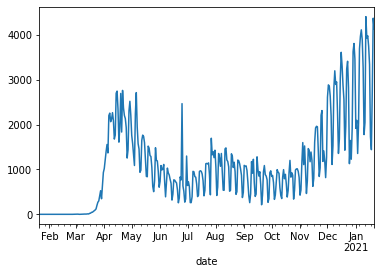

In [22]:
daily_df()['deaths'].plot()

<AxesSubplot:xlabel='date'>

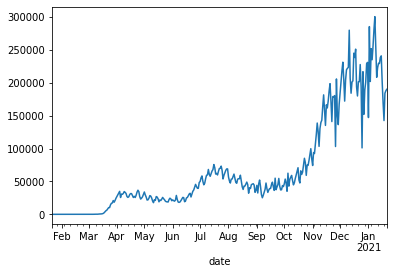

In [23]:
daily_df()['cases'].plot()

In [24]:
daily_df()['cases'].idxmax().strftime("%D"), daily_df()['deaths'].idxmax().strftime("%D")

('01/08/21', '01/12/21')

In [25]:
today = dt.now()
deaths_max = daily_df()['deaths'].idxmax()
cases_max = daily_df()['cases'].idxmax()
cases_delta = today - cases_max
deaths_delta = today - deaths_max

In [26]:
cases_delta.days, deaths_delta.days

(14, 10)

In [31]:
index = states
data = {'cases': [state_df(state).xs(df.index[0])['cases_diff'].sum() for state in states],
        'deaths': [state_df(state).xs(df.index[0])['deaths_diff'].sum() for state in states]}
df3 = pd.DataFrame(data, index)

In [32]:
df3

,cases,deaths
Wyoming,300.0,0.0
Kentucky,3555.0,44.0
Louisiana,3736.0,59.0
Maine,675.0,6.0
Maryland,2167.0,46.0
Iowa,1653.0,51.0
Kansas,456.0,0.0
Mississippi,2290.0,30.0
Missouri,2350.0,41.0
Montana,393.0,8.0


#### first iteration of monthly dataframe

In [33]:
# m_index = df.index.month.unique()
# m_data = {'monthly cases': [df[df.index.month == month]['cases_diff'].sum() for month in m_index],
#         'monthly deaths': [df[df.index.month == month]['deaths_diff'].sum() for month in m_index]}
# m_df = pd.DataFrame(m_data, m_index)
# m_df.index.rename('month', inplace=True)

<AxesSubplot:>

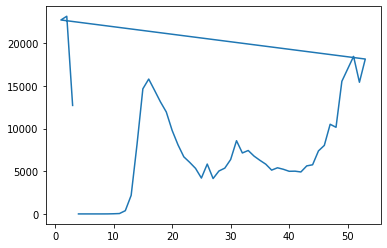

In [34]:
weekly_df()['deaths'].plot()

In [34]:
for week in df.index.isocalendar().week.unique():
    print(week, df[df.index.isocalendar().week == week]['cases_diff'].sum())

53 1484812.0
52 1294505.0
51 1512659.0
50 1541160.0
49 1380238.0
48 1134127.0
47 1199731.0
46 1052521.0
45 783697.0
44 580267.0
43 489173.0
42 398390.0
41 370208.0
40 305972.0
39 313471.0
38 287735.0
37 245475.0
36 283766.0
35 295135.0
34 296183.0
33 361201.0
32 377139.0
31 434918.0
30 458787.0
29 465424.0
28 407471.0
27 346667.0
26 271399.0
25 187867.0
24 151167.0
23 154104.0
22 147870.0
21 157697.0
20 157061.0
19 169385.0
18 194502.0
17 213367.0
16 199454.0
15 219768.0
14 194865.0
13 108172.0
12 28537.0
11 2630.0
10 351.0
9 41.0
8 3.0
7 1.0
6 0.0
5 2.0
4 0.0


In [50]:
df.index.isocalendar().week, df.index.isocalendar().year

(date
 2021-01-21    3
 2021-01-21    3
 2021-01-21    3
 2021-01-21    3
 2021-01-21    3
              ..
 2020-01-24    4
 2020-01-24    4
 2020-01-23    4
 2020-01-22    4
 2020-01-21    4
 Name: week, Length: 952971, dtype: UInt32,
 date
 2021-01-21    2021
 2021-01-21    2021
 2021-01-21    2021
 2021-01-21    2021
 2021-01-21    2021
               ... 
 2020-01-24    2020
 2020-01-24    2020
 2020-01-23    2020
 2020-01-22    2020
 2020-01-21    2020
 Name: year, Length: 952971, dtype: UInt32)

In [25]:
df[df.index.isocalendar().week == df.index.isocalendar().week[-1]]

,county,state,fips,cases,deaths,cases_diff,deaths_diff
date,,,,,,,
2020-01-26,Snohomish,Washington,53061.0,1,0.0,0.0,0.0
2020-01-26,Cook,Illinois,17031.0,1,0.0,0.0,0.0
2020-01-26,Orange,California,6059.0,1,0.0,0.0,0.0
2020-01-26,Los Angeles,California,6037.0,1,0.0,NaN,NaN
2020-01-26,Maricopa,Arizona,4013.0,1,0.0,NaN,NaN
2020-01-25,Snohomish,Washington,53061.0,1,0.0,0.0,0.0
2020-01-25,Cook,Illinois,17031.0,1,0.0,0.0,0.0
2020-01-25,Orange,California,6059.0,1,0.0,NaN,NaN
2020-01-24,Snohomish,Washington,53061.0,1,0.0,0.0,0.0


#### Alternate method for finding total cases:

In [30]:
df[df.index.dayofyear == df.index.dayofyear.max()]['cases'].sum()

15696954

##### last day of the first week

In [31]:
df[df.index.isocalendar().week == df.index.isocalendar().week[-1]].index.max().date()

datetime.date(2020, 1, 26)

In [32]:
df.index[0].strftime("%D"), state_df('New Jersey').xs(df.index[0])['cases_diff'].sum(), state_df('New Jersey').xs(df.index[0])['deaths_diff'].sum()

('12/10/20', 5120.0, 66.0)

<AxesSubplot:xlabel='date'>

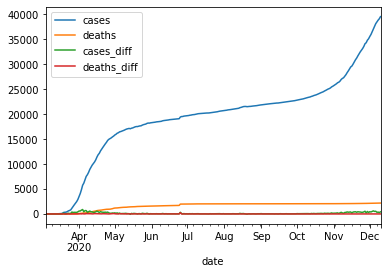

In [33]:
county_df("Bergen").plot()

<AxesSubplot:xlabel='date'>

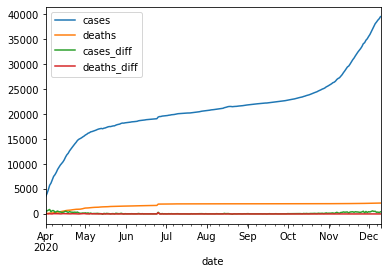

In [34]:
df[(df.index.month >= 4) & (df.state == 'New Jersey') & (df.county == 'Bergen')].drop(columns=['fips']).plot()

In [35]:
county_df("Bergen")

,cases,deaths,cases_diff,deaths_diff
date,,,,
2020-12-10,39557,2187.0,424.0,7.0
2020-12-09,39133,2180.0,279.0,8.0
2020-12-08,38854,2172.0,375.0,7.0
2020-12-07,38479,2165.0,334.0,0.0
2020-12-06,38145,2165.0,543.0,0.0
...,...,...,...,...
2020-03-08,4,0.0,1.0,0.0
2020-03-07,3,0.0,0.0,0.0
2020-03-06,3,0.0,1.0,0.0


In [7]:
state_df("New Jersey").index[-1].strftime("%D")

'03/04/20'

In [6]:
county_df("New York City")['cases_diff'].idxmax().strftime("%D"), county_df("New York City")['cases_diff'].max()

('04/15/20', 8021.0)

<AxesSubplot:xlabel='date'>

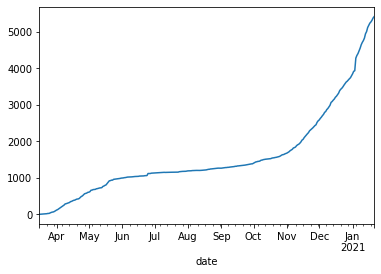

In [17]:
county_df("Hunterdon")['cases'].plot()

In [18]:
county_df("Hunterdon")

,cases,deaths,cases_diff,deaths_diff
date,,,,
2021-01-21,5421,145.0,38.0,0.0
2021-01-20,5383,145.0,62.0,0.0
2021-01-19,5321,145.0,46.0,1.0
2021-01-18,5275,144.0,33.0,0.0
2021-01-17,5242,144.0,61.0,0.0
...,...,...,...,...
2020-03-20,11,0.0,3.0,0.0
2020-03-19,8,0.0,2.0,0.0
2020-03-18,6,0.0,2.0,0.0
